In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

---
### Helper Functions

In [135]:
def getSeriesDF(cid, filename):
    localDF = pd.read_csv('data/Chunks/'+fileName+".csv").drop(columns=['Unnamed: 0'])
    localDF = localDF.loc[localDF['ContestId']==cid]
    localDF = localDF.assign(InvertedTime = localDF['SecondsRemaining'].max()-localDF['SecondsRemaining'])
    localDF = localDF.assign(SummedEntries = localDF['Entries'][::-1].cumsum()[::-1])
    return localDF
def zipCols(col1, col2):
    combined = []
    col1 = list(col1)
    col2 = list(col2)
    for i in range(0, len(col1)):
        combined.append([(col1[i]), col2[i]])
    return combined[::-1]
def combineStatesAndObservations(time, observations, states):
    combined = [[0, 0]]*max(time)
    stateSum = 0
    for i in range(0, len(combined)):
        if(i in list(time)):
            index = list(time).index(i)

            stateSum = states.iloc[index]
            combined[i] = [observations.iloc[index], states.iloc[index]]
        else:
            combined[i] = [0, stateSum]
    return combined

chunkMapDF = pd.read_csv('data/chunkMap.csv')
def getRandomContestAndLocation():
    contest = chunkMapDF.sample(n=1).iloc[0]
    cid, fileName  = contest.ContestId, contest.Chunk
    return cid, fileName

def modelValues(A, B, Times, extended=False):
    y = []
    if(not extended):
        A = np.exp(A)
    for i in Times:
        if(i*B>709):
            val = 42
        else:        
            val = A*math.exp(B*i)
        y.append(val)
    return y

def get100Models(Xs, Times, extended=False):
    results = []
    dif = 1   
    if len(Xs)> 100:
        dif = int(len(Xs)/100.)             
    for i in range(0, len(Xs), dif):
        Xk = Xs[i].tolist()
        results.append(modelValues(Xk[0][0], Xk[1][0], Times, extended = extended))
    return results
def getKindaBigContest():
    cid, fileName = getRandomContestAndLocation()
#     print(cid, fileName)
    fullSeriesDF = getSeriesDF(cid, fileName)
    length = len(fullSeriesDF)
    if length < 10:
        return getKindaBigContest()
    else:
        return fullSeriesDF

def getQ(random_state):
    Q_sub = random_state.randn(2, 2)
    Q = np.dot(Q_sub, Q_sub.transpose())
    val = np.linalg.matrix_rank(Q)
    if(val == 2):
        return Q
    else:
        return getQ()

---
### Kalman Functions

In [3]:
#NOTE! This is the predicted number of entrants based on the current timesetp
def kalmanPredictNextVal(tCurr, xCurr,parameters, extended=False):
    if(extended):
        part1 = np.exp(xCurr[1][0]*tCurr)
        Hk = [part1, part1*(xCurr[0][0]*tCurr)]
        Zk = xCurr[0][0]*np.exp(xCurr[1][0]*tCurr)
#         print("do something")
        return Hk,  Zk
    else:
        Hk = [1., tCurr]
        Zk = np.dot(Hk, xCurr) + np.random.normal(loc=0., scale=parameters['R']) #<----- Consider putting Vk instead of R
        return Hk,  Zk

        # kalmanPredictNextVal(kalmanSeriesDF.iloc[0]['Time'], x0, extended=True)

In [4]:
def goForIt(series, parameters, extended=False):
    Zs = []
    Ys = []
    Hs = []
    Ss = []
    Ps = [] ## Covariance Matrix of Estimate Errors DO P PLEASE
    Ks = [] ## Kalman Gain
    Xs = []
    
    Pk = parameters['P0'] #DONT FORGET TO UPDATE
    Xk = parameters['X0'] #DONT FORGET TO UPDATE
    

    for n in range(0, len(series)):
        actual = np.array(series.iloc[n]['Y']) #Current actual
        time = np.array(series.iloc[n]['Time']) #Current time
    

        Hk, Zk = kalmanPredictNextVal(time, Xk, parameters, extended=extended) #Kalman 
        Yk = actual - Zk # residuals

        transposedH = [[Hk[0]],[Hk[1]]]
        
        Sk_part = np.dot(Hk, Pk)
        Sk = np.dot(Sk_part, transposedH)[0]+parameters['R']
        
        if(Sk==0):
            print("Really??? Y'all bitches trippin... Sk can't be 0 dumby")
            return
        inverseS = 1/Sk  
        
        Kk = np.dot(Pk, transposedH)*inverseS
        Xnext = Xk + Kk*Yk        

        p_part = (np.eye(2)-np.outer(Kk, Hk))
        Pnext = np.dot(p_part, Pk)
        
        #Set new vars based on current observation
        Pk = Pnext
        Xk = Xnext
        
        Zs.append(Zk)
        Ys.append(Yk)
        Hs.append(Hk)
        Ss.append(Sk)
        Ks.append(Kk) ## Kalman Gain
        Xs.append(Xk)
        Ps.append(Pk) 

    return {"Zs": Zs, "Ys": Ys, "Hs":Hs, "Ss":Ss, "Ps":Ps, "Ks": Ks, "Xs": Xs}

---
### Tableview Functions

In [5]:
def tableize(data, label, width = -1):
    widthStr = ""
    if(widthStr != -1):
        widthStr = "width:"+str(width)
    starter = "<table style='display: inline-block; margin:5px; border:thin solid black;'>"
    height = len(data)
    width = len(data[0])
    header = "<tr><th colspan="+str(width)+" style='text-align:center'>"+label+"</th></tr>"
    rows = ""
    for y in range(0, height):
        rows+="<tr >"
        for x in range(0, width):
            rows+="<td>" + str(data[y][x])+"</td>"
        rows+="</tr>"
#     print(data[-1:])
    ender = "</table>"
    return starter+header+rows+ender
# display(HTML(tableize([resultDict['Zs'][-1:]], 'Zs')))
def getResultStats(resultDict):
    Z0str = tableize([resultDict['Zs'][:1]], 'Z0', width="150px")
    Zfstr = tableize([resultDict['Zs'][-1:]], 'Zf', width="150px")

    Y0str = tableize([resultDict['Ys'][:1]], 'Y0')
    Yfstr = tableize([resultDict['Ys'][-1:]], 'Yf')

    H0str = tableize(resultDict['Hs'][-1:], 'H0')
    Hfstr = tableize(resultDict['Hs'][:1], 'Hf')

    S0str = tableize([resultDict['Ss'][-1:]], 'S0')
    Sfstr = tableize([resultDict['Ss'][:1]], 'Sf')

    P0str = tableize(resultDict['Ps'][:1][0], 'P0')
    Pfstr = tableize(resultDict['Ps'][-1:][0], 'Pf')

    K0str = tableize(resultDict['Ks'][:1][0], 'K0')
    Kfstr = tableize(resultDict['Ks'][-1:][0], 'Kf')

    X0str = tableize(resultDict['Xs'][:1][0], 'X0')
    Xfstr = tableize(resultDict['Xs'][-1:][0], 'Xf')
    return ((HTML(K0str+ X0str +P0str+  Z0str)), (HTML(Kfstr+ Xfstr +Pfstr+  Zfstr)))


In [131]:
def KalmanFull(DF, extended=False):
    localDF = DF.copy(deep=True)
    localDF = localDF.assign(LoggedSummedEntries = np.log(localDF['SummedEntries']))
    localDF = localDF.rename({'InvertedTime': 'Time'}, axis=1)
    
    localSeriesDF = localDF.loc[localDF['SecondsRemaining']>=240]
    if((len(localDF)<4)):
        print("Series too short. First Time entry at",localDF['SecondsRemaining'].max(),"minutes remaining")
        return -1
    localCheatDF = localDF.loc[localDF['SecondsRemaining']<=240]

    kSeriesDF = localSeriesDF[['Time', 'LoggedSummedEntries', 'SummedEntries']][::-1]
    if(extended):
        kSeriesDF = kSeriesDF.assign(Y = localDF['SummedEntries'])
    else:
        kSeriesDF = kSeriesDF.assign(Y = localDF['LoggedSummedEntries'])

#----------------------------------------------#
    
    random_state = np.random.RandomState(0)
    F = np.eye(2) #Transition Matrix (Identity Matrix)
#     w = random_state.randn(2, 1) #Noise in the prediction (?) <<<<  FIX THIS
    # Vk = random_state.randn(2, 1) * .1 #Noise in the observation model (?) <<<<  FIX THIS
    Z = list(kSeriesDF['Y']) #Observation matrix
    X0 = [[4.], [.0023]] #Inital parameters guess (?) <<<< NEED VALUES
    P0 = (np.eye(2) + random_state.randn(2, 2)*.1)*100*np.eye(2) #Covariance Matrix (The confidence in our prediction)
    R = random_state.rand()*5.05
    Q = getQ(random_state)
    w = np.random.multivariate_normal([0., 0.], Q)
    parameters = {'random_state':random_state, 'F':F, 'Z':Z, 'X0':X0, 'P0':P0, 'R':R, 'Q':Q, 'w':w}

#----------------------------------------------#
    results = goForIt(kSeriesDF, parameters, extended=extended)
    Xf = results["Xs"][-1:][0].tolist()
    A = Xf[0][0]
    B = Xf[1][0]
    print("A, B", A, B)
#     if(extended == False):
#         A = np.exp(A)
    y = modelValues(A, B, localDF['Time'], extended=extended)
    
#----------------------------------------------#
    fig = plt.figure()
    
    fig.set_size_inches([15, 5])
    ax = fig.add_subplot(111)
#   -     -     -    -    -    -    -    -    -#
 
    oldModels = get100Models(results['Xs'], localDF['Time'], extended=extended)

    numModels = len(oldModels)
    for i in range(0, numModels):
        multiplier = 1/(numModels+1)
        ax.plot(localDF['Time'], oldModels[i], label="Log", alpha=.4, color=(1.-i*multiplier, i*multiplier, 0.), lw=.5)

#   -     -     -    -    -    -    -    -    -#
                             
    lineActual, = ax.plot(localCheatDF['Time'], localCheatDF['SummedEntries'], label="Actual Result", color="purple", ls="--")
    lineObservation, = ax.plot(kSeriesDF['Time'], kSeriesDF['SummedEntries'], label="Raw Observations", color="blue")
    linePrediction, = ax.plot(localDF['Time'], y, label="Prediction", color="red", ls = "--")

#   -     -     -    -    -    -    -    -    -#

    title = "Contest "+str(cid) +"\'s Kalman Filter"
    if(extended):
        title += " (Extended)"

    ax.set_title(title)
    ax.set_xlabel("Minutes Since Start")
    ax.set_xlim(xmin=0.0, xmax=localDF['Time'].max()*1.1)

    ax.set_ylabel("Entries")
    ax.set_ylim(ymin=0.0, ymax=localDF['SummedEntries'].max()*1.2)

#     ax.plot(800, 15000, marker="o", c="")
    ax.grid()
    ax.legend(handles=[lineActual, lineObservation, linePrediction], bbox_to_anchor=(1, 1))
    
#   -     -     -    -    -    -    -    -    -#
   
    initialState, finalState = getResultStats(results)
    display(initialState)
    display(finalState)

In [129]:
chunkMap = pd.read_csv("data/ChunkMap.csv")
def getChunkById(id):
    return chunkMap.loc[chunkMap['ContestId']==id].Chunk
getChunkById(50689524)

373564    chunk38
Name: Chunk, dtype: object

---
### Test!

A, B 7.60575145175675 0.0024551893994615146


A, B 1028.345628834705 0.0030449946013609078


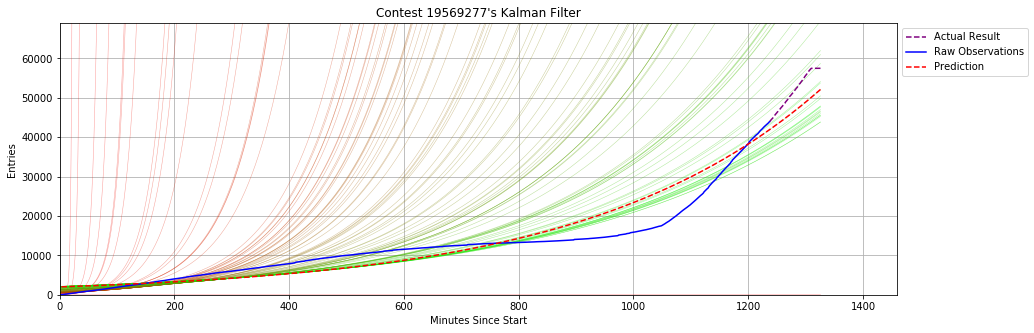

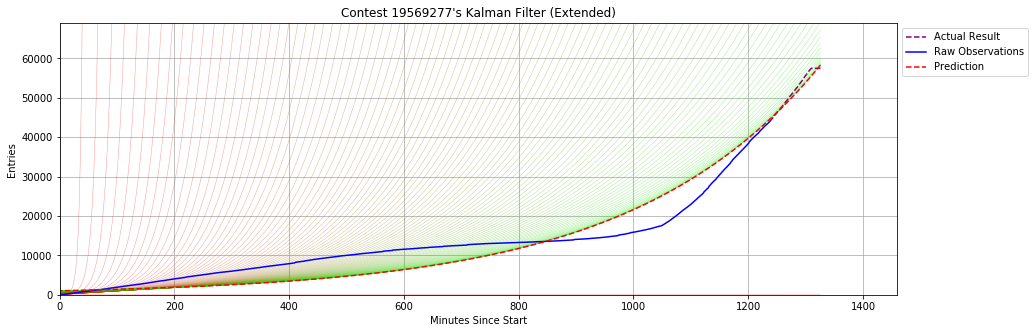

In [136]:
cid, fileName = (19569277, 'chunk8')
aDF = getSeriesDF(cid, fileName)
KalmanFull(aDF, extended=False)
KalmanFull(aDF, extended=True)

A, B 4.991422270030465 0.00865066382023269


A, B 97.94849146996658 0.010334350736720578


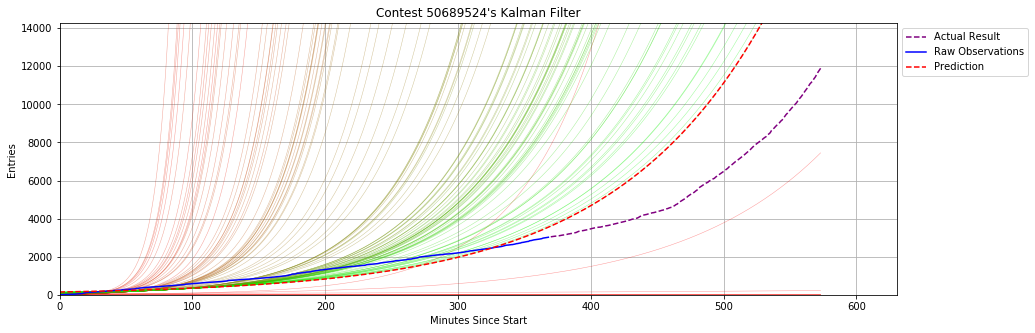

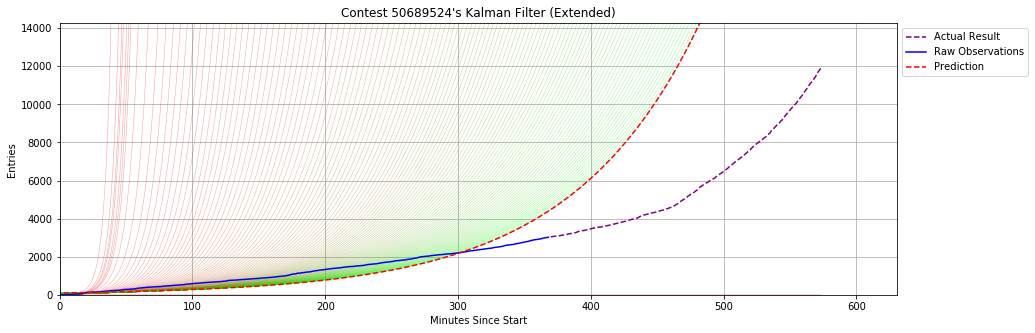

In [137]:
cid, fileName = (50689524, 'chunk38')
aDF = getSeriesDF(cid, fileName)
KalmanFull(aDF, extended=False)
KalmanFull(aDF, extended=True)

A, B 5.37746748456646 0.0004909546443416064


A, B 149.92485993972952 0.0005394119477195135


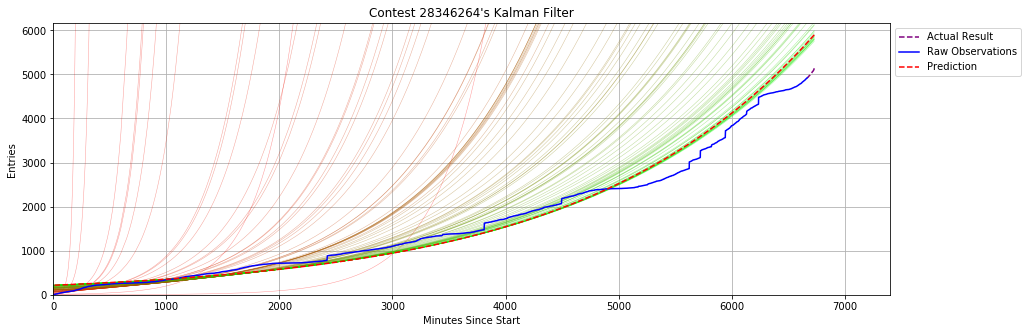

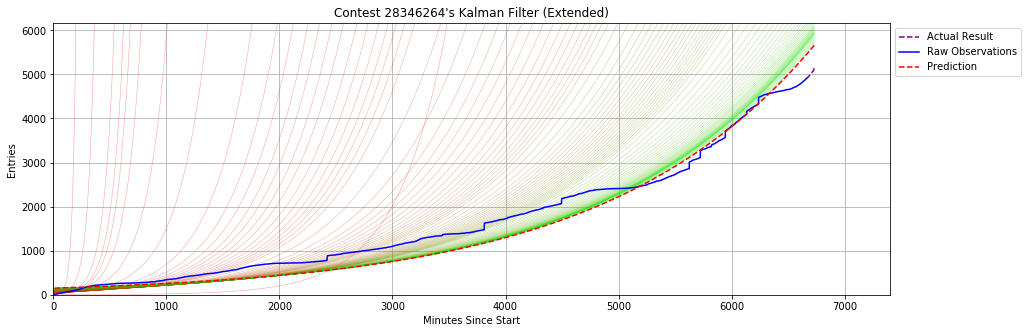

In [138]:
cid, fileName = (28346264, 'chunk47')
aDF = getSeriesDF(cid, fileName)
KalmanFull(aDF, extended=False)
KalmanFull(aDF, extended=True)

A, B 5.362882753632721 0.0005208738961512075


A, B 124.287491954882 0.0006314453061012468


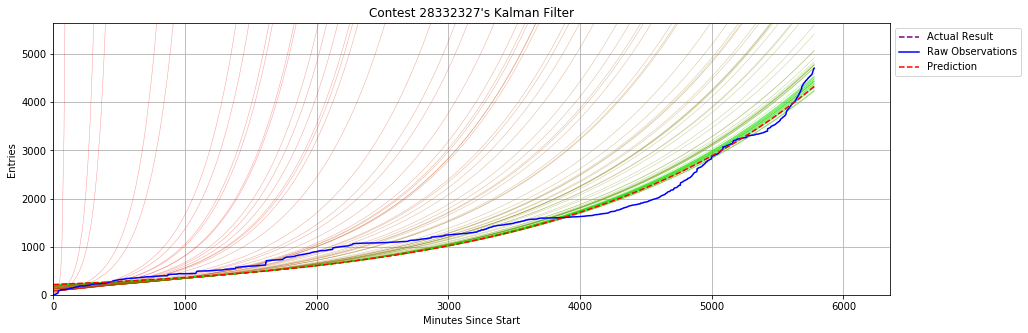

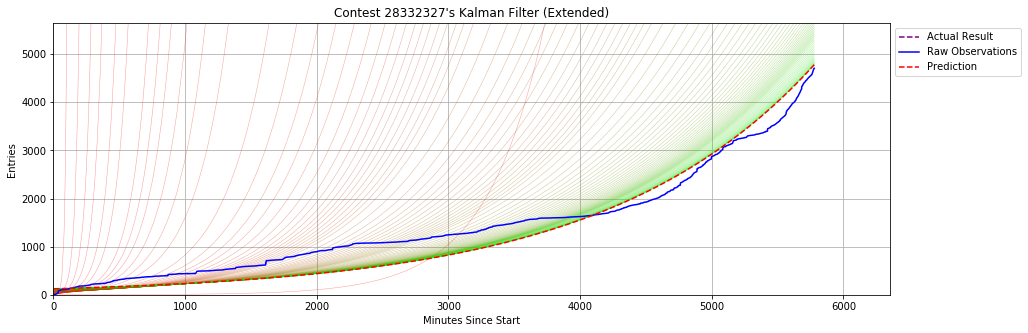

In [139]:
cid, fileName = (28332327, 'chunk47')
aDF = getSeriesDF(cid, fileName)
KalmanFull(aDF, extended=False)
KalmanFull(aDF, extended=True)

A, B 4.273096113920872 0.0050916462011597165


A, B 42.39392682684442 0.005247735205874491


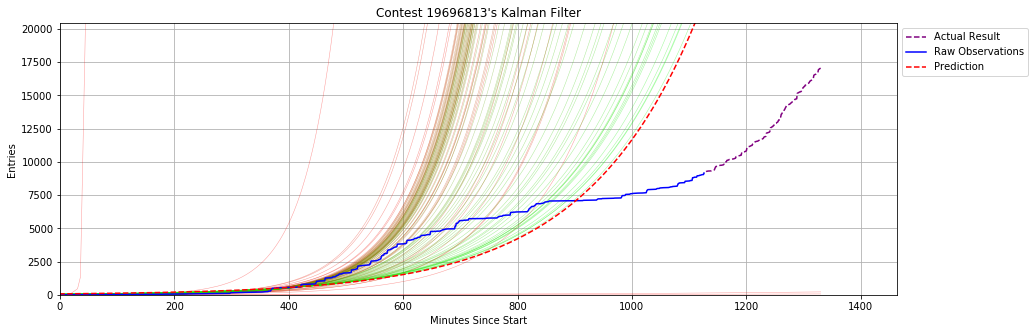

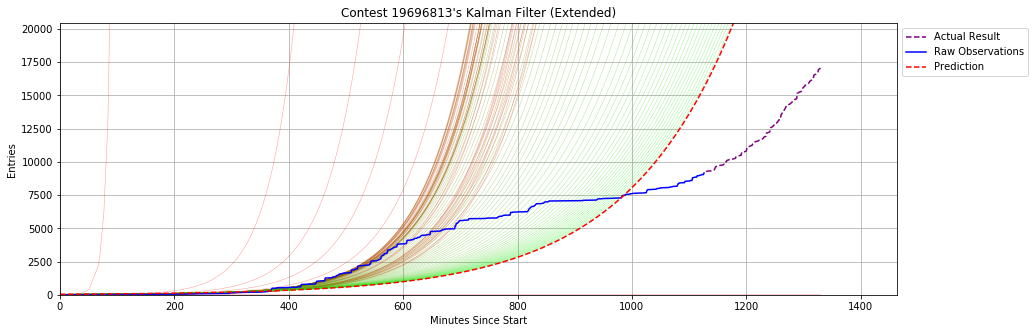

In [140]:
cid, fileName = (19696813, 'chunk8')
aDF = getSeriesDF(cid, fileName)
KalmanFull(aDF, extended=False)
KalmanFull(aDF, extended=True)

A, B 4.308202229827408 0.0042224632337749335


A, B 48.79489171222114 0.00456349811356993


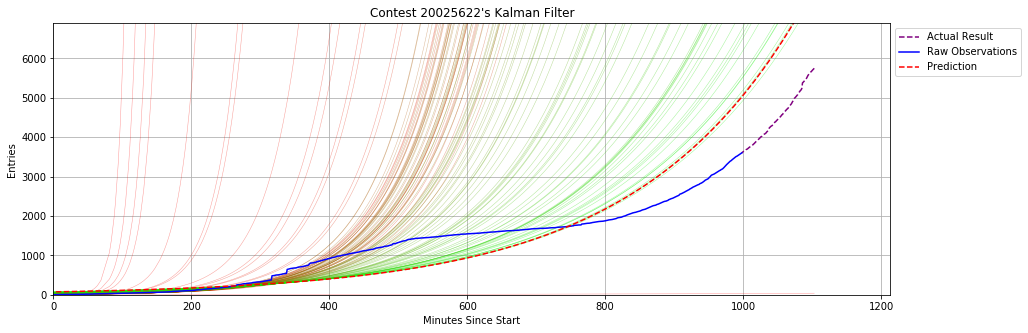

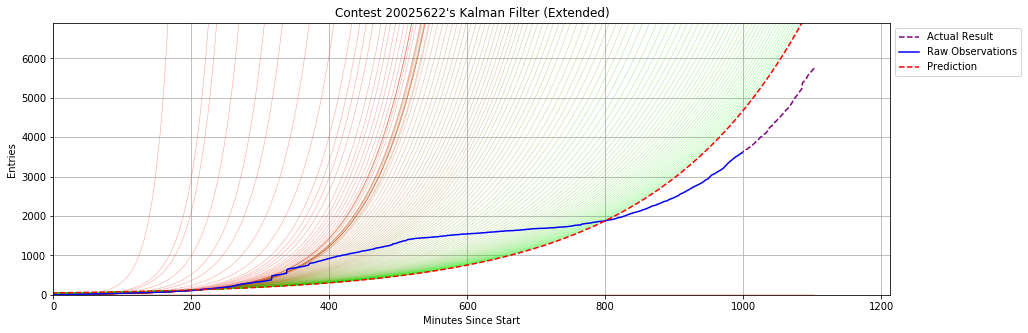

In [141]:
cid, fileName = (20025622, 'chunk9')
aDF = getSeriesDF(cid, fileName)
KalmanFull(aDF, extended=False)
KalmanFull(aDF, extended=True)

A, B 6.544550983915819 0.004161697466332607


A, B 411.0655889197999 0.004476211171361139


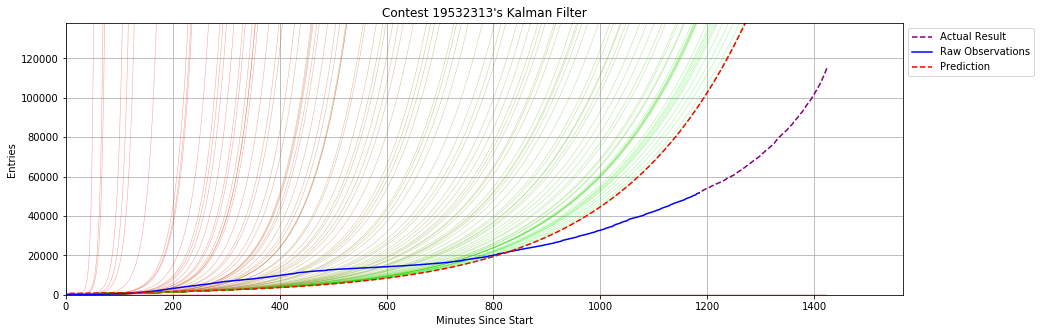

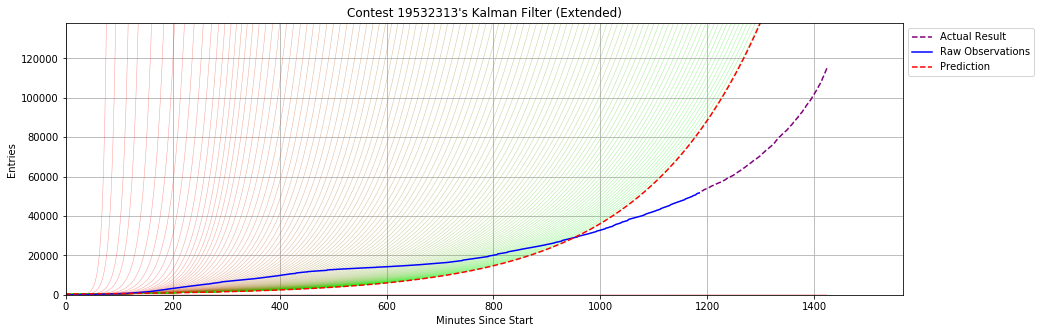

In [142]:
cid, fileName = (19532313, 'chunk8')
aDF = getSeriesDF(cid, fileName)
KalmanFull(aDF, extended=False)
KalmanFull(aDF, extended=True)

A, B 5.893570898184117 0.004171077749559256


A, B 271.616328550637 0.004079536069589014


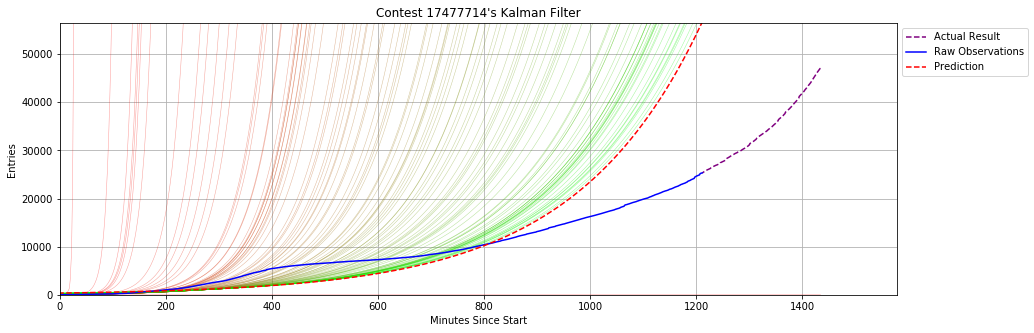

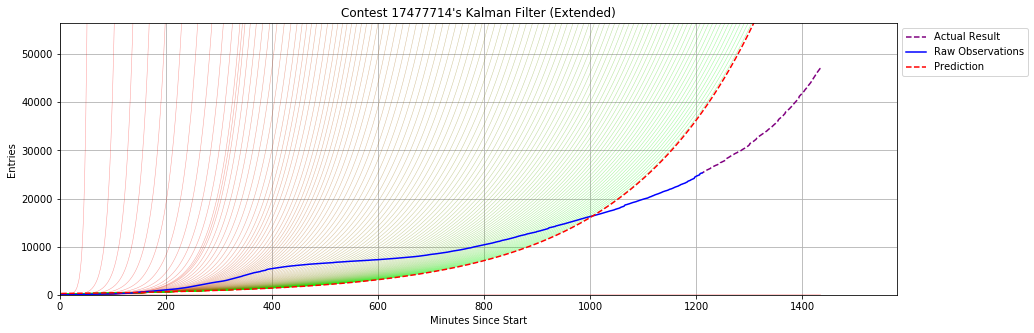

In [143]:
# cid, fileName = (52772327, 'chunk14')
cid, fileName = (17477714, 'chunk34')
aDF = getSeriesDF(cid, fileName)
KalmanFull(aDF, extended=False)
KalmanFull(aDF, extended=True)

A, B 2.044788463316636 0.0026534049500290028


A, B 6.955207840351869 0.002504236528050833


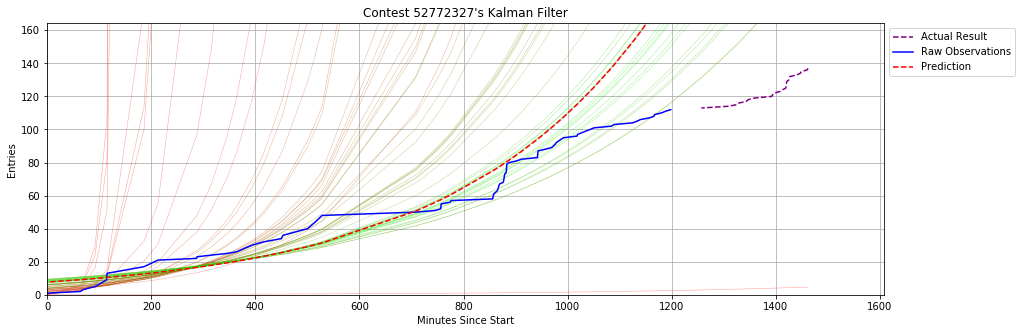

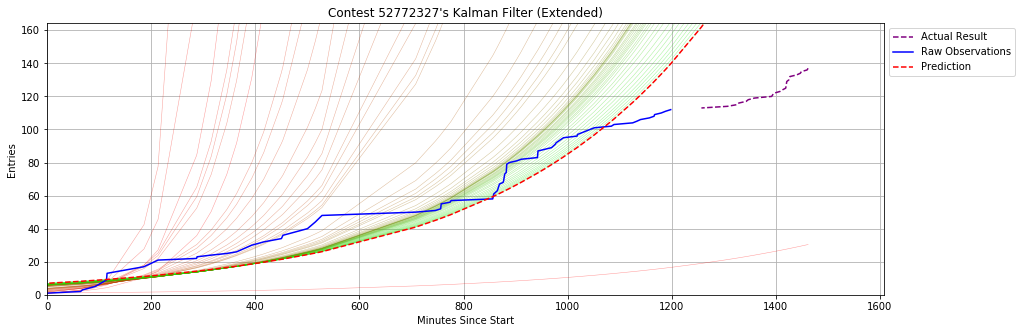

In [144]:
cid, fileName = (52772327, 'chunk14')
aDF = getSeriesDF(cid, fileName)
KalmanFull(aDF, extended=False)
KalmanFull(aDF, extended=True)